In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.mlab as mlab
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import itertools
import math
import random
import networkx as nx
import colorsys
import pandas as pd
from pyomo.opt import SolverFactory
from pyomo.core import Var
import pyomo.environ as en

import seaborn as sns
from scipy import stats 
from six.moves import cPickle as pickle
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from __future__ import division

%matplotlib inline
sns.set_style({'axes.linewidth': 1, 'axes.edgecolor':'black', 'xtick.direction': \
               'out', 'xtick.major.size': 4.0, 'ytick.direction': 'out', 'ytick.major.size': 4.0, \
              'axes.facecolor': 'white','grid.color': '.8', 'grid.linestyle': u'-', 'grid.linewidth': 0.5})


In [4]:
testProfiles = np.genfromtxt('TestData.csv', delimiter=',')
prices = np.genfromtxt('./IntermediateData/testPrices.csv', delimiter=',')
# lines 0-10 are demand
# lines 10-20 are generation

In [5]:
def cycleCharging(noUnits, storageProperties, load, price, billingOption):
    # the input should have generation as +ve
    
    # make sure the load is in kW, then storage and price are adjusted using width of time period

    seriesLength=len(load)
    demand = -load
    original_demand = np.zeros((seriesLength))
    original_demand[ np.where(load<0)[0] ] = -load[ np.where(load<0)[0] ]
    
    ### ------------------------- ESS properties ----------------- ###
    maxSOC = noUnits*storageProperties[0]# kWh
    # scale maxSOC appropriately
    maxChg = noUnits*storageProperties[1] # kW
    maxDisChg = noUnits*storageProperties[2] # kW
    etaChg = storageProperties[3]
    etaDisChg = storageProperties[4]
    ### ---------------------------------------------------------- ###

    ### ------------------------- CHOOSE POLICY OPTION ----------- ###
    policyOption = billingOption[0]
    ### ---------------------------------------------------------- ###
    
    priceSolarExport = billingOption[1]
    solarExports = np.zeros((seriesLength))
    exports = np.zeros((seriesLength))
    buy_price = np.zeros((seriesLength))
    for i in range(seriesLength):
        buy_price[i] = price[i]
        if demand[i] < 0:
            solarExports[i]=-demand[i]
            exports[i] = solarExports[i]
            demand[i] = 0
    # now alter the price in the periods where there is solar available (if req.)
    buy_price[ np.where(solarExports>0)[0] ] = priceSolarExport
    
    # get the storage profiles
    SOC = np.zeros((seriesLength))
    deltaSOC = np.zeros((seriesLength))

    # calculate initial costs
    oldPrice = np.zeros((seriesLength))
    for i in range(seriesLength):
        oldPrice[i]=(price[i]*demand[i] - solarExports[i]*buy_price[i])
    oldTotalPrice = np.sum( oldPrice )

    # cycle through the series
    for i in range(seriesLength):
        bottleneck = np.zeros((3))
        if exports[i]>0:
            # establish the min bottleneck for charging
            bottleneck[0] = maxSOC - SOC[i-1]
            bottleneck[1] = maxChg
            bottleneck[2] = exports[i]*etaChg
            # act on the min bottleneck
            actual_bottleneck = np.min(bottleneck) 
            exports[i] = exports[i] - actual_bottleneck/etaChg
            SOC[i] = SOC[i-1] + actual_bottleneck
            deltaSOC[i] = 0 + actual_bottleneck
        else:
            # establish the min bottleneck for discharging
            bottleneck[0] = SOC[i-1]
            bottleneck[1] = -maxDisChg
            bottleneck[2] = demand[i]/etaDisChg
            # operate on the actual bottleneck
            actual_bottleneck = np.min(bottleneck)
            demand[i] = demand[i] - actual_bottleneck*etaDisChg
            SOC[i] = SOC[i-1] - actual_bottleneck
            deltaSOC[i] = 0 - actual_bottleneck
            
    newPrice = np.zeros((seriesLength))
    for i in range(seriesLength):
        newPrice[i] = (price[i]*demand[i] - exports[i]*buy_price[i])
    newTotalPrice = np.sum ( newPrice )
    #print oldTotalPrice - newTotalPrice
    
    #now calculate the new demand
    newDemand = demand-exports
    SOC = SOC
    
    return newDemand, oldTotalPrice, newTotalPrice, SOC

In [6]:
def priceDriven2(noUnits, storageProperties, load, price, billingOption):
    price1 = np.copy(price)
    seriesLength=len(load)
    demand = -load
    original_demand = np.zeros((seriesLength))
    original_demand[ np.where(load<0)[0] ] = -load[ np.where(load<0)[0] ]

    ### ------------------------- ESS properties ----------------- ###
    maxSOC = noUnits*storageProperties[0]# kWh # scale maxSOC appropriately
    maxChg = noUnits*storageProperties[1] # kW
    maxDisChg = noUnits*storageProperties[2] # kW
    etaChg = storageProperties[3]
    etaDisChg = storageProperties[4]
    ### ---------------------------------------------------------- ###
    ### ------------------------- CHOOSE POLICY OPTION ----------- ###
    policyOption = billingOption[0] # solar export price, but must be used locally first
    marketArbitrage = billingOption[2]
    ### ---------------------------------------------------------- ###
    priceSolarExport = billingOption[1]

    solarExports = np.zeros((seriesLength))
    exports = np.zeros((seriesLength))
    buy_price = np.zeros((seriesLength))
    for i in range(seriesLength):
        buy_price[i] = price1[i]
        if policyOption == 1:
            if demand[i] < 0:
                solarExports[i]=-demand[i]
                exports[i] = solarExports[i]
                demand[i] = 0
    # now alter the price in the periods where there is solar available (if req.)
    buy_price[ np.where(solarExports>0)[0] ] = priceSolarExport
    buy_price1 = np.copy(buy_price)

    # get the storage profiles
    SOC = np.zeros((seriesLength))
    deltaSOC = np.zeros((seriesLength))

    # calculate initial costs
    oldPrice = np.zeros((seriesLength))
    for i in range(seriesLength):
        oldPrice[i]=price1[i]*demand[i] - solarExports[i]*buy_price[i]
    oldTotalPrice = np.sum( oldPrice )

    removeMINH = np.ones((seriesLength))
    removeMAXH = np.ones((seriesLength))

    if policyOption==1:
        # alter the price slightly to discharge as soon as load>PV (reality)
        for j in range(len(price1)):
            #if solarExports[j]<=0:
            price1[j] = price1[j]+(8760-j)/100000000.
            buy_price1[j] = buy_price1[j]+(j)/100000000.
            
    else:
        # alter the price to make the algorithm faster if there are lots of similar prices (buy early sell late encouraged)
        for j in range(len(price)):
            #if demand[i] >= 0:
            price1[j] = price1[j]+(8760-j)/100000000. #price1[j] = price1[j]+np.random.uniform(low=-0.5, high=0.5)/10000000
            buy_price1[j] = price[j]+(j)/100000000. 

    while np.any(removeMAXH) == True:
        #for iiii in range(1):
        matrix = np.zeros(( 2, len ( np.where(removeMAXH==True)[0] ) ))
        matrix[0,:] = np.where(removeMAXH==True)[0]
        matrix[1,:] = price1[ np.where(removeMAXH==True)[0] ]
        #print removeMAXH
        #print removeMINH
        indici = np.where( matrix[1,:]==np.max( matrix[1,:] ) )[0]
        #print indici
        maxh = np.int(matrix[0,indici[0]])

        #print 'Maxh = ', maxh

        # find the last hour before maxh when storage was full
        r1 = np.where( SOC[0:maxh+1] == maxSOC )[0]
        #print r1.size
        if r1.size == 0:
            r1 = 0
        else:
            r1 = np.where( SOC[0:maxh+1] == maxSOC )[0][-1]+1
        # find the first hour after maxh when storage is empty
        r2 = np.where( SOC[maxh:] == 0 )[0]
        if r2.size == 0:
            r2 = len(SOC)
        else:
            r2 = np.where( SOC[maxh:] == 0 )[0][0]+maxh-1

        #print 'r1 = ', r1
        #print 'r2 = ', r2

        # find the minh in the time range
        range_price = buy_price1[r1:r2+1]
        range_remove = removeMINH[r1:r2+1]
        #print range_remove
        #print range_price
        # if there is no hour in the range then remove maxh and skip to the end

        if np.any(range_remove) == False:
            removeMAXH[maxh]=False
        else:
            matrix = np.zeros(( 2, len ( np.where(range_remove==True)[0] ) ))
            matrix[0,:] = np.where(range_remove==True)[0]
            matrix[1,:] = range_price[ np.where(range_remove==True)[0] ]

            indici = np.where( matrix[1,:]==np.min( matrix[1,:] ) )[0]
            minh = np.int( matrix[0,indici[0]] + r1 )

            MoC = buy_price[minh]/(etaChg*etaDisChg)
            #print 'Minh = ', minh

            if ((MoC<price[maxh]) and (minh!=maxh)):

                bottleneck = np.zeros((5))
                bottleneck[0] = deltaSOC[maxh]-maxDisChg
                bottleneck[1] = maxChg - deltaSOC[minh]
                if maxh > minh:
                    bottleneck[2] = maxSOC - np.max(SOC[minh:maxh+1])
                else:
                    bottleneck[2] = np.min(SOC[maxh:minh+1])

                ############### ARBITRAGE ###########################   cannot output more than local consumption
                if marketArbitrage == False:
                    if demand[maxh]>0:
                        bottleneck[3] = demand[maxh]/etaDisChg
                    else:
                        bottleneck[3] = 0
                else: # the market arbitrage allowed case is yet to be tested
                    bottleneck[3] = maxSOC

                # if there is export initally cannot store more than export
                if exports[minh] > 0:
                    bottleneck[4] = exports[minh]*etaChg
                else:
                    bottleneck[4] = maxSOC
                #print bottleneck
                actual_bottleneck = np.min(bottleneck)  

                # Update the aggregated demand
                demand[maxh] = demand[maxh] - actual_bottleneck*etaDisChg
                # if not buying from solar increase the demand at minh
                if exports[minh] <= 0:
                    demand[minh] = demand[minh] + actual_bottleneck/etaChg

                # update the storage charging schedule
                exports[minh] = exports[minh] - actual_bottleneck/etaChg
                deltaSOC[minh] = deltaSOC[minh] + actual_bottleneck
                deltaSOC[maxh] = deltaSOC[maxh] - actual_bottleneck
                if maxh>minh:
                    SOC[minh:maxh] = SOC[minh:maxh] + actual_bottleneck
                else:
                    SOC[maxh:minh] = SOC[maxh:minh] - actual_bottleneck

                # account for rounding errors
                if demand[maxh] < 0 + 0.0001 and demand[maxh] > 0 - 0.0001:
                    demand[maxh] = 0
                if exports[minh] < 0 + 0.0001:
                    exports[minh] = 0
                    # update the price
                    if policyOption==1:
                        buy_price1[minh] = price[minh]+(minh)/100000000.
                        buy_price[minh] = price[minh]

                # check if at the charge or discharge operation is at capacity at either
                # maxh or minh and remove that hour from the price distribution.
                if deltaSOC[maxh] <= maxDisChg:
                    removeMAXH[maxh] = False
                    removeMINH[maxh] = False
                if deltaSOC[minh] >= maxChg:
                    removeMINH[minh] = False
                    removeMAXH[minh] = False

                ######################## ARBITRAGE #####################
                # check whether exports are allowed or not
                if marketArbitrage == False:
                    # if not remove periods where all demand is met
                    if demand[maxh] <= 0:
                        removeMAXH[maxh] = False

            else:
                # if there is no price incentive remove the hours
                removeMAXH[maxh] = False
                removeMAXH[minh] = False
                #removeMINH[maxh] = False
                #removeMINH[minh] = False

    newPrice = np.zeros((seriesLength))
    for i in range(seriesLength):
        newPrice[i] = price[i]*demand[i] - exports[i]*buy_price[i]
    newTotalPrice = np.sum ( newPrice )
    newDemand = demand-exports
    
    return newDemand, oldTotalPrice, newTotalPrice, SOC

In [7]:
def priceDriven(noUnits, storageProperties, load, price, billingOption):
    
    price1 = np.copy(price)
    seriesLength=len(load)
    demand = -load
    original_demand = np.zeros((seriesLength))
    original_demand[ np.where(load<0)[0] ] = -load[ np.where(load<0)[0] ]

    ### ------------------------- ESS properties ----------------- ###
    maxSOC = noUnits*storageProperties[0]# kWh
    # scale maxSOC appropriately
    maxChg = noUnits*storageProperties[1] # kW
    maxDisChg = noUnits*storageProperties[2] # kW
    etaChg = storageProperties[3]
    etaDisChg = storageProperties[4]
    ### ---------------------------------------------------------- ###


    ### ------------------------- CHOOSE POLICY OPTION ----------- ###
    policyOption = billingOption[0] # solar export price, but must be used locally first
    marketArbitrage = billingOption[2]
    ### ---------------------------------------------------------- ###
    
    
    priceSolarExport = billingOption[1]
    solarExports = np.zeros((seriesLength))
    exports = np.zeros((seriesLength))
    buy_price = np.zeros((seriesLength))
    for i in range(seriesLength):
        buy_price[i] = price[i]
        if policyOption == 1:
            if demand[i] < 0:
                solarExports[i]=-demand[i]
                exports[i] = solarExports[i]
                demand[i] = 0
    # now alter the price in the periods where there is solar available (if req.)
    buy_price[ np.where(solarExports>0)[0] ] = priceSolarExport
    
    # get the storage profiles
    SOC = np.zeros((seriesLength))
    deltaSOC = np.zeros((seriesLength))

    # calculate initial costs
    oldPrice = np.zeros((seriesLength))
    for i in range(seriesLength):
        oldPrice[i]=price[i]*demand[i] - solarExports[i]*buy_price[i]
    oldTotalPrice = np.sum( oldPrice )

    remove = np.ones((seriesLength))
    
    if policyOption==1:
        # alter the price to cheat slightly
        for j in range(len(price)):
            if solarExports[j]<=0:
                price[j] = price[j]+(8760-j)/100000000.
    else:
        # alter the price to cheat slightly
        for j in range(len(price)):
            price[j] = price[j]+np.random.uniform(low=-0.5, high=0.5)/10000000
    
            
    while np.any(remove) == True:
        #for iii in range(1):
        matrix = np.zeros(( 3, len ( np.where(remove==True)[0] ) ))
        matrix[0,:] = np.where(remove==True)[0]
        matrix[1,:] = price[ np.where(remove==True)[0] ]
        matrix[2,:] = buy_price[ np.where(remove==True)[0] ]
        #print matrix
        indici = np.where( matrix[1,:]==np.max( matrix[1,:] ) )[0]
        #print indici
        # try and preferentially select maxh according to minh
        priceMatch = np.where( matrix[1,:]==matrix[2,:] )[0]
        #print priceMatch
        maxh = np.int(matrix[0,indici[0]])

        #print 'Maxh = ', maxh

        # find the last hour before maxh when storage was full
        r1 = np.where( SOC[0:maxh+1] == maxSOC )[0]
        #print r1.size
        if r1.size == 0:
            r1 = 0
        else:
            r1 = np.where( SOC[0:maxh+1] == maxSOC )[0][-1]+1
        # find the first hour after maxh when storage is empty
        r2 = np.where( SOC[maxh:] == 0 )[0]
        if r2.size == 0:
            r2 = len(SOC)
        else:
            r2 = np.where( SOC[maxh:] == 0 )[0][0]+maxh-1

        #print 'r1 = ', r1
        #print 'r2 = ', r2

        # find the minh in the time range
        range_price = buy_price[r1:r2+1]
        range_remove = remove[r1:r2+1]
        #print range_remove
        # if there is no hour in the range then remove maxh and skip to the end

        if np.any(range_remove) == False:
            remove[maxh]=False
        else:
            matrix = np.zeros(( 2, len ( np.where(range_remove==True)[0] ) ))
            matrix[0,:] = np.where(range_remove==True)[0]
            matrix[1,:] = range_price[ np.where(range_remove==True)[0] ]
            #print matrix
            indici = np.where( matrix[1,:]==np.min( matrix[1,:] ) )[0]
            minh = np.int( matrix[0,indici[0]] + r1 )

            MoC = buy_price[minh]/(etaChg*etaDisChg)
            #print 'Minh = ', minh

            if MoC<price[maxh] and [minh!=maxh]:

                bottleneck = np.zeros((5))
                bottleneck[0] = deltaSOC[maxh]-maxDisChg
                bottleneck[1] = maxChg - deltaSOC[minh]
                if maxh > minh:
                    bottleneck[2] = maxSOC - np.max(SOC[minh:maxh+1])
                else:
                    bottleneck[2] = np.min(SOC[maxh:minh+1])

                ############### ARBITRAGE ###########################    
                # initially cannot output more than local consumption
                if marketArbitrage == False:
                    if demand[maxh]>0:
                        bottleneck[3] = demand[maxh]/etaDisChg
                    else:
                        bottleneck[3] = 0
                else:
                    bottleneck[3] = maxSOC

                # if there is export initally cannot store more than export
                if exports[minh] > 0:
                    bottleneck[4] = exports[minh]*etaChg
                else:
                    bottleneck[4] = maxSOC
                #print bottleneck
                actual_bottleneck = np.min(bottleneck)  

                # Update the aggregated demand
                demand[maxh] = demand[maxh] - actual_bottleneck*etaDisChg
                # if not buying from solar increase the demand at minh
                if exports[minh] <= 0:
                    demand[minh] = demand[minh] + actual_bottleneck/etaChg

                # update the storage charging schedule
                exports[minh] = exports[minh] - actual_bottleneck/etaChg
                deltaSOC[minh] = deltaSOC[minh] + actual_bottleneck
                deltaSOC[maxh] = deltaSOC[maxh] - actual_bottleneck
                if maxh>minh:
                    SOC[minh:maxh] = SOC[minh:maxh] + actual_bottleneck
                else:
                    SOC[maxh:minh] = SOC[maxh:minh] - actual_bottleneck

                # account for rounding errors
                if demand[maxh] < 0 + 0.0001 and demand[maxh] > 0 - 0.0001:
                    demand[maxh] = 0
                if exports[minh] < 0 + 0.0001:
                    exports[minh] = 0
                    # update the price
                    buy_price[minh] = price[minh]

                #print SOC
                #print deltaSOC

                # check if at the charge or discharge operation is at capacity at either
                # maxh or minh and remove that hour from the price distribution.
                if deltaSOC[maxh] <= maxDisChg:
                    remove[maxh] = False
                if deltaSOC[minh] >= maxChg:
                    remove[minh] = False

                ######################## ARBITRAGE #####################
                # check whether exports are allowed or not
                if marketArbitrage == False:
                    # if not remove periods where all demand is met
                    if demand[maxh] <= 0:
                        remove[maxh] = False
                # else: do nothing

            else:
                # if there is no price incentive remove the hours
                remove[maxh] = False
                remove[minh] = False
                
    newPrice = np.zeros((seriesLength))
    for i in range(seriesLength):
        newPrice[i] = price1[i]*demand[i] - exports[i]*buy_price[i]
    newTotalPrice = np.sum ( newPrice )
    newDemand = demand-exports

    return newDemand, oldTotalPrice, newPrice, SOC

In [8]:
# These are the storage device properties
cycles = 3000
maxLi = 30
installedCap = 1 # kWh
maxDOD = 0.85 # % equivalent full cycle (EFC)
EoL = 0.8 # end of life % equivalent full charge 
maxSOC = np.mean([EoL*installedCap, maxDOD*installedCap])# kWh
minSOC = 0 # kWh
maxChg = 0.5 # kW
maxDisChg = -0.5 # kW
etaChg = 0.9
etaDisChg = 0.9

# Make a list of the storage properties to pass to the functions
storageProperties = []
storageProperties.append(maxSOC-minSOC) 
storageProperties.append(maxChg) 
storageProperties.append(maxDisChg) 
storageProperties.append(etaChg) 
storageProperties.append(etaDisChg) 

# billingOption is a list that describes what pricing scheme in in effect 
# 1=FIT and 2=NEM
# If a FIT is specified then an export price is required.
billingOption = []
billingChoice = 1 # 1 means feed in tariff
priceExport = 0 # cents/kWh
# choose whether device is allowed to buy and sell back to grid
marketArbitrage = False
billingOption.append(billingChoice) 
billingOption.append(priceExport)
billingOption.append(marketArbitrage)

In [80]:
load = testProfiles[0]-testProfiles[10]
# load = np.ones((8760))*2
# prices[0,0:90]
#load = np.ones(len(load))*10
price = prices[2,0:len(load)]
billingOption[0] = 2 # 1 means feed in tariff
billingOption[1] = 10 # solar export price

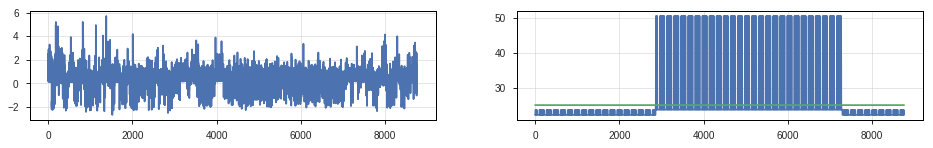

In [81]:
# simulate a 10 kWh battery
fig = plt.figure(figsize=(16,2))
ax1=fig.add_subplot(121)
plt.plot(np.arange(0,len(price)), load)
ax2 = fig.add_subplot(122)
plt.plot(np.arange(0,len(price)), price)
if billingOption[0] == 1:
    plt.plot(np.arange(0,len(price)), np.ones(len(price))*billingOption[1])

In [82]:
# how big is the battery
noUnitsSim = 10

In [83]:
if billingOption[0]==1:
    
    modelPrice1 = np.zeros(len(price))
    for j in range(len(price)):
        modelPrice1[j] = price[j]+(8760-j)/1000000.
    modelPrice2 = np.zeros(len(price))
    for j in range(len(price)):
        modelPrice2[j] = price[j]+(j)/1000000.
    priceDict1 = dict(enumerate(modelPrice1))
    priceDict2 = dict(enumerate(modelPrice2))

    # split load into +ve and -ve
    posLoad = np.copy(load)
    negLoad = np.copy(load)
    for j,e in enumerate(load):
        if e>=0:
            negLoad[j]=0
        else:
            posLoad[j]=0
    # print posLoad
    # print negLoad
    posLoadDict = dict(enumerate(posLoad))
    negLoadDict = dict(enumerate(negLoad))

    # want the MILP model to charge early when PV>load (this is likely reality), so provide a very small incentive with the FIT
    FITseries = np.ones(len(price))*billingOption[1]
    for j in range(len(price)):
        FITseries[j] = FITseries[j] + j/1000000.
    FITDict = dict(enumerate(FITseries))
    
    # model
    m = en.ConcreteModel()

    # set
    m.Time = en.RangeSet(0, len(price)-1)

    # variables
    m.SOC = en.Var(m.Time, bounds=(0,noUnitsSim*storageProperties[0]), initialize=0)
    m.posDeltaSOCGrid = en.Var(m.Time, bounds=(0,noUnitsSim*storageProperties[1]), initialize=0)
    m.posDeltaSOCPV = en.Var(m.Time, bounds=(0,noUnitsSim*storageProperties[1]), initialize=0)
    m.negDeltaSOC = en.Var(m.Time, bounds=(noUnitsSim*storageProperties[2],0), initialize=0)
    m.posEInGrid = en.Var(m.Time, initialize=0.)
    m.posEInPV = en.Var(m.Time, initialize=0)
    m.negEOut = en.Var(m.Time, initialize=0)
    m.posNetLoad = en.Var(m.Time, initialize=posLoadDict)
    m.negNetLoad = en.Var(m.Time, initialize=negLoadDict)

    # m.helperVar = en.Var(m.Time, initialize=10.)
    m.Bool_char=en.Var(m.Time,within=en.Boolean)
    m.Bool_dis=en.Var(m.Time,within=en.Boolean,initialize=0)

    # parameters
    m.price1 = en.Param(m.Time, initialize=priceDict1)
    m.price2 = en.Param(m.Time, initialize=priceDict2)
    m.posLoad = en.Param(m.Time, initialize=posLoadDict)
    m.negLoad = en.Param(m.Time, initialize=negLoadDict)
    m.FIT = en.Param(m.Time, initialize=FITDict)
    m.etaChg = en.Param(initialize = etaChg)
    m.etaDisChg = en.Param(initialize = etaDisChg)
    m.ChargingLimit = en.Param(initialize=5.)

    # objective function
    def Obj_fn(m):
        #return sum((m.price1[i]*m.posNetLoad[i]) + (m.FIT[i]*m.negNetLoad[i]) for i in m.Time)
        return sum((m.posEInGrid[i]*m.price2[i]+m.negEOut[i]*m.price1[i]) for i in m.Time) + \
                sum((m.FIT[i]*m.posEInPV[i]) for i in m.Time)
    # ...
    m.total_cost = en.Objective(rule=Obj_fn,sense=en.minimize)

    # constraints
    def SOC_rule(m,t):
        if t==0:
            return (m.SOC[t] == m.posDeltaSOCGrid[t]+m.posDeltaSOCPV[t]+m.negDeltaSOC[t])
        else:
            return (m.SOC[t] == m.SOC[t-1]+m.posDeltaSOCGrid[t]+m.posDeltaSOCPV[t]+m.negDeltaSOC[t])   
    m.Batt_SOC = en.Constraint(m.Time,rule=SOC_rule)
    
    # boolean constraints
    # not actually needed - no need to formulate as MILP, LP is sufficient
    def Bool_char_rule_1(m,i):
        bigM=500
        return((m.posDeltaSOCGrid[i]+m.posDeltaSOCPV[i])>=-bigM*(m.Bool_char[i]))
    m.Batt_ch1=en.Constraint(m.Time,rule=Bool_char_rule_1)
    def Bool_char_rule_2(m,i):
        bigM=500
        return((m.posDeltaSOCGrid[i]+m.posDeltaSOCPV[i])<=0+bigM*(1-m.Bool_dis[i]))
    m.Batt_ch2=en.Constraint(m.Time,rule=Bool_char_rule_2)
    def Bool_char_rule_3(m,i):
        bigM=500
        return((m.negDeltaSOC[i])<=bigM*(m.Bool_dis[i]))
    m.Batt_cd3=en.Constraint(m.Time,rule=Bool_char_rule_3)
    def Bool_char_rule_4(m,i):
        bigM=500
        return((m.negDeltaSOC[i])>=0-bigM*(1-m.Bool_char[i]))
    m.Batt_cd4=en.Constraint(m.Time,rule=Bool_char_rule_4)
    def Batt_char_dis(m,i):
        return (m.Bool_char[i]+m.Bool_dis[i],1)
    m.Batt_char_dis=en.Constraint(m.Time,rule=Batt_char_dis)

    #ensure charging efficiency is divided
    def pos_E_in_Grid_rule(m,i):
        return m.posEInGrid[i] == m.posDeltaSOCGrid[i]/m.etaChg
    m.posEInGrid_cons = en.Constraint(m.Time, rule=pos_E_in_Grid_rule)
    def pos_E_in_PV_rule(m,i):
        return m.posEInPV[i] == m.posDeltaSOCPV[i]/m.etaChg
    m.posEInPV_cons = en.Constraint(m.Time, rule=pos_E_in_PV_rule)
    # ensure discharging eff multiplied
    def neg_E_out_rule(m,i):
        return m.negEOut[i] == m.negDeltaSOC[i]*m.etaDisChg
    m.negEOut_cons = en.Constraint(m.Time, rule=neg_E_out_rule)

    # ensure battery can only discharge to demand level
    def E_netLoad_rule(m,i):
        return m.negEOut[i]+m.posLoad[i]>=0
    m.demand_cons = en.Constraint(m.Time, rule=E_netLoad_rule)

    # ensure PV charging can only come from PV
    def E_PV_rule(m,i):
        return m.posEInPV[i]+m.negLoad[i]<=0
    m.EPVchargingLimit_cons = en.Constraint(m.Time, rule=E_PV_rule)

    # ensure charging rate obeyed
    def E_charging_rate_rule(m,i):
        return m.posDeltaSOCPV[i]+m.posDeltaSOCGrid[i]<=m.ChargingLimit
    m.chargingLimit_cons = en.Constraint(m.Time, rule=E_charging_rate_rule)

    # calculate the net positive demand
    def E_pos_net_rule(m,i):
        return m.posNetLoad[i] == m.posLoad[i]+m.posEInGrid[i]+m.negEOut[i]
    m.E_posNet_cons = en.Constraint(m.Time,rule=E_pos_net_rule)

    # calculate export
    def E_neg_net_rule(m,i):
        return m.negNetLoad[i] == m.negLoad[i]+m.posEInPV[i] # EInPV only (PV rule) and battery cannot discharge (netLoad rule)
    m.E_negNet_cons = en.Constraint(m.Time,rule=E_neg_net_rule)

In [84]:
if billingOption[0]==2:
    modelPrice1 = np.zeros(len(price))
    for j in range(len(price)):
        modelPrice1[j] = price[j]+(j)/1000000.
    modelPrice2 = np.zeros(len(price))
    for j in range(len(price)):
        modelPrice2[j] = price[j]+(8760-j)/1000000.
    priceDict1 = dict(enumerate(modelPrice1))
    priceDict2 = dict(enumerate(modelPrice2))
    
    #modelPrice1 = np.zeros(len(price))
    #for j in range(len(price)):
    #    modelPrice1[j] = price[j]+(j)/1000000.
    #priceDict1 = dict(enumerate(modelPrice1))

    # split load into +ve and -ve
    posLoad = np.copy(load)
    negLoad = np.copy(load)
    for j,e in enumerate(load):
        if e>=0:
            negLoad[j]=0
        else:
            posLoad[j]=0
    # print posLoad
    # print negLoad
    posLoadDict = dict(enumerate(posLoad))
    negLoadDict = dict(enumerate(negLoad))

    # model
    m = en.ConcreteModel()

    # set
    m.Time = en.RangeSet(0, len(price)-1)

    # variables
    m.SOC = en.Var(m.Time, bounds=(0,noUnitsSim*storageProperties[0]), initialize=0)
    m.posDeltaSOCGrid = en.Var(m.Time, bounds=(0,noUnitsSim*storageProperties[1]), initialize=0)
    m.posDeltaSOCPV = en.Var(m.Time, bounds=(0,noUnitsSim*storageProperties[1]), initialize=0)
    m.negDeltaSOC = en.Var(m.Time, bounds=(noUnitsSim*storageProperties[2],0), initialize=0)
    m.posEInGrid = en.Var(m.Time, initialize=0.)
    m.posEInPV = en.Var(m.Time, initialize=0)
    m.negEOut = en.Var(m.Time, initialize=0)
    m.posNetLoad = en.Var(m.Time, initialize=posLoadDict)
    m.negNetLoad = en.Var(m.Time, initialize=negLoadDict)

    m.Bool_char=en.Var(m.Time,within=en.Boolean)
    m.Bool_dis=en.Var(m.Time,within=en.Boolean,initialize=0)

    # parameters
    m.price1 = en.Param(m.Time, initialize=priceDict1)
    m.price2 = en.Param(m.Time, initialize=priceDict2)
    m.posLoad = en.Param(m.Time, initialize=posLoadDict)
    m.negLoad = en.Param(m.Time, initialize=negLoadDict)
    m.etaChg = en.Param(initialize = etaChg)
    m.etaDisChg = en.Param(initialize = etaDisChg)
    m.ChargingLimit = en.Param(initialize=5.)

    # objective function
    def Obj_fn(m):
        return sum(( (m.posEInGrid[i]+m.posEInPV[i])*m.price1[i]+m.negEOut[i]*m.price2[i]) for i in m.Time)
    # ...
    m.total_cost = en.Objective(rule=Obj_fn,sense=en.minimize)
    
    # boolean constraints
    # not actually needed - no need to formulate as MILP, LP is sufficient
    def Bool_char_rule_1(m,i):
        bigM=500
        return((m.posDeltaSOCGrid[i]+m.posDeltaSOCPV[i])>=-bigM*(m.Bool_char[i]))
    m.Batt_ch1=en.Constraint(m.Time,rule=Bool_char_rule_1)
    def Bool_char_rule_2(m,i):
        bigM=500
        return((m.posDeltaSOCGrid[i]+m.posDeltaSOCPV[i])<=0+bigM*(1-m.Bool_dis[i]))
    m.Batt_ch2=en.Constraint(m.Time,rule=Bool_char_rule_2)
    def Bool_char_rule_3(m,i):
        bigM=500
        return((m.negDeltaSOC[i])<=bigM*(m.Bool_dis[i]))
    m.Batt_cd3=en.Constraint(m.Time,rule=Bool_char_rule_3)
    def Bool_char_rule_4(m,i):
        bigM=500
        return((m.negDeltaSOC[i])>=0-bigM*(1-m.Bool_char[i]))
    m.Batt_cd4=en.Constraint(m.Time,rule=Bool_char_rule_4)
    def Batt_char_dis(m,i):
        return (m.Bool_char[i]+m.Bool_dis[i],1)
    m.Batt_char_dis=en.Constraint(m.Time,rule=Batt_char_dis)

    # constraints
    def SOC_rule(m,t):
        if t==0:
            return (m.SOC[t] == m.posDeltaSOCGrid[t]+m.posDeltaSOCPV[t]+m.negDeltaSOC[t])
        else:
            return (m.SOC[t] == m.SOC[t-1]+m.posDeltaSOCGrid[t]+m.posDeltaSOCPV[t]+m.negDeltaSOC[t])   
    m.Batt_SOC = en.Constraint(m.Time,rule=SOC_rule)

    #ensure charging efficiency is divided
    def pos_E_in_Grid_rule(m,i):
        return m.posEInGrid[i] == m.posDeltaSOCGrid[i]/m.etaChg
    m.posEInGrid_cons = en.Constraint(m.Time, rule=pos_E_in_Grid_rule)
    def pos_E_in_PV_rule(m,i):
        return m.posEInPV[i] == m.posDeltaSOCPV[i]/m.etaChg
    m.posEInPV_cons = en.Constraint(m.Time, rule=pos_E_in_PV_rule)
    # ensure discharging eff multiplied
    def neg_E_out_rule(m,i):
        return m.negEOut[i] == m.negDeltaSOC[i]*m.etaDisChg
    m.negEOut_cons = en.Constraint(m.Time, rule=neg_E_out_rule)

    # ensure battery can only discharge to demand level
    def E_netLoad_rule(m,i):
        return m.negEOut[i]+m.posLoad[i]>=0
    m.demand_cons = en.Constraint(m.Time, rule=E_netLoad_rule)

    # ensure PV charging can only come from PV
    def E_PV_rule(m,i):
        return m.posEInPV[i]+m.negLoad[i]<=0
    m.EPVchargingLimit_cons = en.Constraint(m.Time, rule=E_PV_rule)

    # ensure charging rate obeyed
    def E_charging_rate_rule(m,i):
        return m.posDeltaSOCPV[i]+m.posDeltaSOCGrid[i]<=m.ChargingLimit
    m.chargingLimit_cons = en.Constraint(m.Time, rule=E_charging_rate_rule)

    # calculate the net positive demand
    def E_pos_net_rule(m,i):
        return m.posNetLoad[i] == m.posLoad[i]+m.posEInGrid[i]+m.negEOut[i]
    m.E_posNet_cons = en.Constraint(m.Time,rule=E_pos_net_rule)

    # calculate export
    def E_neg_net_rule(m,i):
        return m.negNetLoad[i] == m.negLoad[i]+m.posEInPV[i] # EInPV only (PV rule) and battery cannot discharge (netLoad rule)
    m.E_negNet_cons = en.Constraint(m.Time,rule=E_neg_net_rule)

In [85]:
#print m.total_cost.expr
import time

In [86]:
# set the path to the solver
opt = SolverFactory("cplex", executable="/opt/ibm/ILOG/CPLEX_Studio1271/cplex/bin/x86-64_linux/cplex")

t = time.time()
results = opt.solve(m)
elapsed = time.time() - t
print elapsed

12.5681068897


In [87]:
SOC = np.zeros((len(price)))
posDeltaSOCGrid = np.zeros((len(price)))
posDeltaSOCPV = np.zeros((len(price)))
negDeltaSOC = np.zeros((len(price)))
posEInGrid = np.zeros((len(price)))
posEInPV = np.zeros((len(price)))
negEOut = np.zeros((len(price)))
posNetLoad = np.zeros((len(price)))
negNetLoad = np.zeros((len(price)))
j = 0
for v in m.component_objects(Var, active=True):
    #print ("Variable component object",v)
    #print ("Type of component object: ", str(type(v))[1:-1])
    varobject = getattr(m, str(v))
    for index in varobject:
        if j == 0:
            #print j, index, varobject[index].value
            SOC[index] = varobject[index].value
        elif j == 1:
            posDeltaSOCGrid[index] = varobject[index].value
        elif j == 2:
            posDeltaSOCPV[index] = varobject[index].value
        elif j == 3:
            negDeltaSOC[index] = varobject[index].value
        elif j == 4:
            posEInGrid[index] = varobject[index].value
        elif j == 5:
            posEInPV[index] = varobject[index].value
        elif j == 6:
            negEOut[index] = varobject[index].value
        elif j == 7:
            posNetLoad[index] = varobject[index].value
        elif j == 8:
            negNetLoad[index] = varobject[index].value
    j+=1

In [88]:
netLoad = posNetLoad+negNetLoad
# print posEInGrid
# print posNetLoad
# print negNetLoad

In [89]:
min(SOC)

0.0

In [90]:
t = time.time()
[newDemand1, oldTotalPrice1, newTotalPrice1, SOC1] = cycleCharging(10, storageProperties, -load, price, billingOption)
print time.time() - t
t = time.time()
[newDemand2, oldTotalPrice2, newTotalPrice2, SOC2] = priceDriven(10, storageProperties, -load, price, billingOption)
print time.time() - t

0.129508972168
1.81999802589


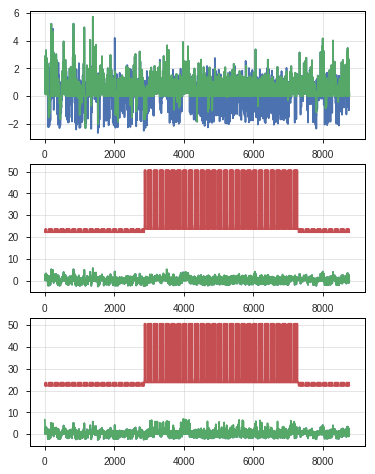

In [91]:
fig = plt.figure(figsize = (6,8))
ax1 = fig.add_subplot(311)
ax1.plot(np.arange(0,len(load)), load)
ax1.plot(np.arange(0,len(load)), newDemand1)
ax2 = fig.add_subplot(312)
ax2.plot(np.arange(0,len(load)), load)
ax2.plot(np.arange(0,len(load)), newDemand2)
ax2.plot(np.arange(0,len(load)), price)
ax3 = fig.add_subplot(313)
ax3.plot(np.arange(0,len(load)), load)
ax3.plot(np.arange(0,len(load)), netLoad)
ax3.plot(np.arange(0,len(load)), price)

In [92]:
if billingOption[0] == 1:
    print sum([newDemand1[x]*price[x] for x in range(len(price)) if newDemand1[x]>0]) + \
            sum([newDemand1[x]*billingOption[1] for x in range(len(price)) if newDemand1[x]<0])
    print sum([newDemand2[x]*price[x] for x in range(len(price)) if newDemand2[x]>0]) + \
            sum([newDemand2[x]*billingOption[1] for x in range(len(price)) if newDemand2[x]<0])
    print sum([netLoad[x]*price[x] for x in range(len(price)) if netLoad[x]>0]) + \
            sum([netLoad[x]*billingOption[1] for x in range(len(price)) if netLoad[x]<0])
else:
    print sum([newDemand1[x]*price[x] for x in range(len(price))])
    print sum([newDemand2[x]*price[x] for x in range(len(price))])
    print sum([netLoad[x]*price[x] for x in range(len(price))])

85798.7292433
74177.4812366
74177.4812502


In [77]:
A = netLoad - newDemand2
print np.where(A<-1)[0]
print np.where(A>1)[0]

[]
[]
